# Problem

In this work I train a random forest classifier model to predict the severity of differents accidents. I use a NLP sentimental analisis to add sens to the description feature, I could do this part training a logitic reggresion model with a bag of words.

# Features

The data correspond to traffic accident records in the US between 2016 and 2021.

The two first columns don't say nothing.

The 'Severity' column contains the severity of the accident (0 means low, 1 means high)

Then I have:

- Start hour of the accident.

- Final hour of the accident.

- Initial latitude of the accident.

- Initial longitude of the accident.

- Final latitude of the accident.

- Final longitude of the accident.

- The lenght of the accident.

- A description made by humans.

- Street number and name.

- Side of the street.

- City.

- County.

- State.

- Zip code.

- Timezone.

- Airport Code where is located the closest meteorological station to the accident.

- Time when the weather was measured.

- Temperature.

- Temperature of the wind.

- Humidity.

- Presure.

- Visibility.

- Wind direction.

- Weather condition (clear, sun, snow, etc).

- Amenities in the vicinity of the accident.

- Presence of street bump.

- Presence of street cross.

- Presence of yield sign.

- Presence of street intersection.

- Presence of no exit sign.

- Presence of train rails.

- Presence of roundabout.

- Presence of service station.

- Presence of stop sign.

- Presence of traffic calming.

- Presence of traffic signals.

- Presence of turning loop.

- Night or day according to the sunrise and sunset.

- Night or day according to the civil twilight (the street light is necessary or not).

- Night or day according to the nautical twilight.

- Night or day according to the astronomical twilight.


In [1]:
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer, word_tokenize  
from sklearn.feature_extraction.text import TfidfVectorizer 
import warnings

warnings.filterwarnings("ignore")

filename = 'data.csv'

df = pd.read_csv(filename)
df.drop(['Unnamed: 0.1', 'Unnamed: 0','Country'], axis=1, inplace=True)

In [2]:
len(df)

45834

In [3]:
df['Severity'].value_counts()

0    28072
1    17762
Name: Severity, dtype: int64

In [4]:
print(f'Number of descriptions: {len(df["Description"].unique())}')
a=[len(set(i.split())) for i in df['Description']]
print(f'Words average by description: {sum(a)/len(a)}')
a1=[len(set(k.split())) for l,k in enumerate(df["Description"]) if df["Severity"][l] == 1]
a0=[len(set(k.split())) for l,k in enumerate(df["Description"]) if df["Severity"][l] == 0]
print(f'Words average by description with severity 1: {sum(a1)/len(a1)}')
print(f'Words average by description with severity 0: {sum(a0)/len(a0)}')

Number of descriptions: 39677
Words average by description: 12.12019461535105
Words average by description with severity 1: 13.432946740231955
Words average by description with severity 0: 11.289576802507836


## Dommy variables 

In [5]:
st_year,st_month,st_day,st_hour,st_min=([],[],[],[],[])
et_year,et_month,et_day,et_hour,et_min=([],[],[],[],[])

for date in df[['Start_Time','End_Time']].iterrows():
    d10split1 = date[1][0].split('-')
    d10split2 = d10split1[2].split(' ')[1].split(':')
    st_year.append(int(d10split1[0]))
    st_month.append(int(d10split1[1]))
    st_day.append(int(d10split1[2].split(' ')[0]))
    st_hour.append(int(d10split2[0]))
    st_min.append(int(d10split2[1]))
    
    d11split1 = date[1][1].split('-')
    d11split2 = d11split1[2].split(' ')[1].split(':')
    et_year.append(int(d11split1[0]))
    et_month.append(int(d11split1[1]))
    et_day.append(int(d11split1[2].split(' ')[0]))
    et_hour.append(int(d11split2[0]))
    et_min.append(int(d11split2[1]))

df['st_year'] = st_year
df['st_month'] = st_month
df['st_day'] = st_day
df['st_hour'] = st_hour
#df['st_min'] = st_min
df['et_year'] = et_year
df['et_month'] = et_month
df['et_day'] = et_day
df['et_hour'] = et_hour
#df['et_min'] = et_min

wt_year,wt_month,wt_day,wt_hour,wt_min=([],[],[],[],[])

for date in df['Weather_Timestamp']:
    d10split1 = date.split('-')
    d10split2 = d10split1[2].split(' ')[1].split(':')
    wt_year.append(int(d10split1[0]))
    wt_month.append(int(d10split1[1]))
    wt_day.append(int(d10split1[2].split(' ')[0]))
    wt_hour.append(int(d10split2[0]))
    wt_min.append(int(d10split2[1]))

df['wt_year'] = wt_year
df['wt_month'] = wt_month
df['wt_day'] = wt_day
df['wt_hour'] = wt_hour
#df['wt_min'] = wt_min

df.drop(['Start_Time', 'End_Time','Weather_Timestamp'], axis=1, inplace=True)


In [6]:
zipcode=[]
for i in df['Zipcode']:
    zipcode.append(int(i[:5]))
df['Zipcode'] = zipcode

timezone=[]
for tz in df['Timezone']:
    if tz== 'US/Eastern':
        timezone.append(0)
    elif tz== 'US/Pacific':
        timezone.append(1)
    elif tz== 'US/Central':
        timezone.append(2)
    elif tz== 'US/Mountain':
        timezone.append(3)
df['Timezone'] = timezone

positions = []
for position in df[['State','County','City','Street','Number']].iterrows():
    positions.append(position[1][0]+' '+
          position[1][1]+' '+
          position[1][2]+' '+
          str(position[1][3])+' '+
          str(position[1][4]))
df['Positions'] = positions

i=1
pos_order = {}
for value in df['Positions'].value_counts().items():
    pos_order[value[0]] = i
    i+=1
    
pos_vals = []
for pos in df['Positions']:
    pos_vals.append(pos_order[pos])
df['Positions'] = pos_vals

df.drop(['State','County','City','Street','Number'], axis=1, inplace=True)

i=1
aircod_order = {}
for value in df['Airport_Code'].value_counts().items():
    aircod_order[value[0]] = i
    i+=1
    
aircod_vals = []
for pos in df['Airport_Code']:
    aircod_vals.append(aircod_order[pos])
df['Airport_Code'] = aircod_vals

i=1
windir_order = {}
for value in df['Wind_Direction'].value_counts().items():
    windir_order[value[0]] = i
    i+=1
    
windir_vals = []
for pos in df['Wind_Direction']:
    windir_vals.append(windir_order[pos])
df['Wind_Direction'] = windir_vals

i=1
weacon_order = {}
for value in df['Weather_Condition'].value_counts().items():
    weacon_order[value[0]] = i
    i+=1
    
weacon_vals = []
for pos in df['Weather_Condition']:
    weacon_vals.append(weacon_order[pos])
df['Weather_Condition'] = weacon_vals

sunrise=[]
for sunr in df['Sunrise_Sunset']:
    if sunr == 'Night':
        sunrise.append(0)
    elif sunr == 'Day':
        sunrise.append(1)
df['Sunrise_Sunset'] = sunrise

civilt=[]
for civt in df['Civil_Twilight']:
    if civt == 'Night':
        civilt.append(0)
    elif civt == 'Day':
        civilt.append(1)
df['Civil_Twilight'] = civilt

nauti=[]
for nau in df['Nautical_Twilight']:
    if nau == 'Night':
        nauti.append(0)
    elif nau == 'Day':
        nauti.append(1)
df['Nautical_Twilight'] = nauti

astro=[]
for ast in df['Astronomical_Twilight']:
    if ast == 'Night':
        astro.append(0)
    elif ast == 'Day':
        astro.append(1)
df['Astronomical_Twilight'] = astro

sides=[]
for side in df['Side']:
    if side == 'R':
        sides.append(0)
    elif side == 'L':
        sides.append(1)
df['Side'] = sides

In [7]:
features=['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Zipcode', 'Airport_Code', 'Pressure(in)', 'st_year', 'st_month', 'et_year', 'et_month', 'wt_year', 'wt_month', 'Positions']

## Split data

In [8]:
indxs = df[df.Severity.eq(0)].sample(10310).index
df.drop(indxs, inplace=True)
y = np.array(df['Severity'])
df.drop(['Severity'], axis=1, inplace=True)

In [9]:
X = df[features+['Description']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

## NPL Description

In [11]:
tokenizer = TweetTokenizer()
        # La forma en la que "trabaja" la función es la siguiente:
        # armo un vectorizador que aplica TF-IDF, y en este vectorizador
        # elijo el rango de n_grams con que quiero trabajar y selecciono el tokenizador que quiero usar.
        # Se le aclara al tokenizador que tiene que tokenizar el texto utilizando la función tokenize
vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
    
        # Armo una lista con todo el texto que tenga y entreno el vectorizador con todo este texto
        # luego transformo estos por separado en su versión vectorizada
    
full_text = list(X_train["Description"].values)
vectorizer.fit(full_text) # Solo entreno el vectorizador con el x_train test, esto para evitar
                          # un tipo de data lakage llamado premature featurization, además, si
                          # si tomara todo el train test, el accuracy estimado no sería el correcto.
    
X_train_vectorized = vectorizer.transform(X_train["Description"])
X_test_vectorized = vectorizer.transform(X_test["Description"])

lgr = LogisticRegression(C= 5.38, penalty= 'l2',random_state=42)
lgr.fit(X_train_vectorized, y_train)
print(f"Accuracy description LogisticRegression: {accuracy_score(lgr.predict(X_test_vectorized) , y_test)}")

Accuracy description LogisticRegression: 0.9765434415462564


In [12]:
X_train["Description"] = list(lgr.predict_proba(X_train_vectorized)[:,0])
X_test["Description"] = list(lgr.predict_proba(X_test_vectorized)[:,0])

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [14]:

param_grid = { 
    'n_estimators': [775,1000],
    'max_features': [None],
    'max_depth' : [7.5,9.75],
    'criterion' : ['entropy'],
    'ccp_alpha' : [1e-18,1e-13]
}

In [15]:
rfc = RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)


KeyboardInterrupt



In [ ]:
CV_rfc.best_params_

In [ ]:
rfc1 = RandomForestClassifier(random_state=42,criterion= 'entropy',
                              max_depth= 10.2,
                              max_features= 'auto',
                              n_estimators= 460,ccp_alpha=1e-10)
rfc1.fit(X_train, y_train)

In [ ]:
y_hat_test = rfc1.predict_proba(X_test)[:, 1]
y_hat_train = rfc1.predict_proba(X_train)[:, 1]

# evaluo el AUC
roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
print(f"ROC AUC RDF: {roc_test , roc_train}") #0.9992742045365184

In [ ]:
auc_values_test = [] # aca es donde van a ir a parar los AUCs de cada fold
auc_values_train = []
contador=1

fig = plt.figure(figsize=(10, 5))
curves=[]

for i in range(4):

    indxs = df_train[df_train.Severity.eq(0)].sample(10310).index
    df_train_1 = df_train.drop(indxs).copy()
    
    y = np.array(df_train_1['Severity'])
    
    df_train_1.drop(['Severity'], axis=1, inplace=True)
    
    # vamos a entrenar un modelo usando únicamente variables asociadas a clima
    # columnas_clima = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)','Visibility(mi)',  'Wind_Speed(mph)','Precipitation(in)']

    # extraigo la matriz de features X
    X = df_train_1[features4+['Description']]

    skf = StratifiedKFold(n_splits=3,shuffle =True)
    skf.get_n_splits(X, y) 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y[train_index], y[test_index]
        tokenizer = TweetTokenizer()
        # La forma en la que "trabaja" la función es la siguiente:
        # armo un vectorizador que aplica TF-IDF, y en este vectorizador
        # elijo el rango de n_grams con que quiero trabajar y selecciono el tokenizador que quiero usar.
        # Se le aclara al tokenizador que tiene que tokenizar el texto utilizando la función tokenize
        vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
    
        # Armo una lista con todo el texto que tenga y entreno el vectorizador con todo este texto
        # luego transformo estos por separado en su versión vectorizada
    
        full_text = list(X_train["Description"].values)
        vectorizer.fit(full_text) # Solo entreno el vectorizador con el x_train test, esto para evitar
                          # un tipo de data lakage llamado premature featurization, además, si
                          # si tomara todo el train test, el accuracy estimado no sería el correcto.
    
        X_train_vectorized = vectorizer.transform(X_train["Description"])
        X_test_vectorized = vectorizer.transform(X_test["Description"])
        test_vectorized = vectorizer.transform(df_test["Description"])

        lgr = LogisticRegression()
        lgr.fit(X_train_vectorized,y_train)
        print(f"Accuracy description LogisticRegression: {accuracy_score(lgr.predict(X_test_vectorized) , y_test)}")
    
    
        predict_vals_tr=[]
        predict_vals_ts=[]
        pred_tr = list(lgr.predict_proba(X_train_vectorized))
        pred_ts = list(lgr.predict_proba(X_test_vectorized))
        for ptr in pred_tr:
            predict_vals_tr.append(ptr[0])
        for pts in pred_ts:
            predict_vals_ts.append(pts[0])

        X_train["Description"] = predict_vals_tr
        X_test["Description"] = predict_vals_ts
    
        X_train = np.array(X_train)
        X_test = np.array(X_test)
    
        # pruebo con un random forest así como viene de fábrica
        #clf = RandomForestClassifier(random_state=42,criterion= 'entropy',
        #                             max_depth= 10,
        #                             max_features= None,
        #                             n_estimators= 493,ccp_alpha=1e-10)
        clf=LogisticRegression(C= 1.2067926406393288,penalty= 'l2')
        
        # ajusto el modelo

        clf.fit(X_train, y_train)

        # armo el vector de predicciones.
        y_hat_test = clf.predict_proba(X_test)[:, 1]
        y_hat_train = clf.predict_proba(X_train)[:, 1]

        # evaluo el AUC
        roc_test = roc_auc_score(y_test, y_hat_test)
        roc_train = roc_auc_score(y_train, y_hat_train)
        print(f"{contador} ROC AUC RDF: {roc_test , roc_train}")
        auc_values_test.append(roc_test)
        auc_values_train.append(roc_train)
        contador = contador + 1
        curves.append(calibration_curve(y_test, y_hat_test, n_bins = 10, normalize = True))

In [ ]:
print(np.mean(auc_values_test),np.std(auc_values_test))#(0.99854 0.00068)
print(np.mean(auc_values_train),np.std(auc_values_train))

In [ ]:
fig = plt.figure(figsize=(10, 5))

for yv,xv in curves:
    plt.plot(xv, yv,'o')
xy =np.linspace(0,1,100)

plt.plot(xy,xy,'.')
plt.tight_layout()
plt.show()

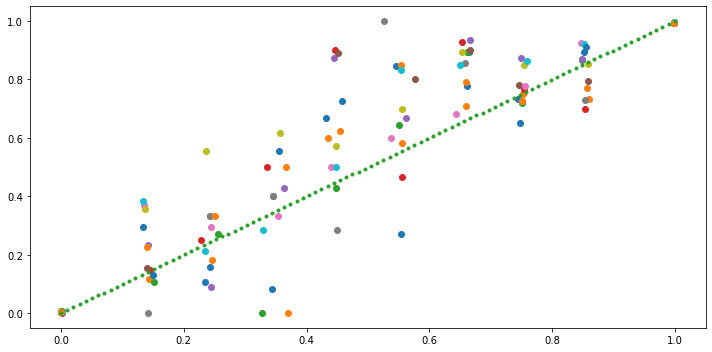

In [16]:
fig = plt.figure(figsize=(10, 5))

for yv,xv in curves:
    plt.plot(xv, yv,'o')
xy =np.linspace(0,1,100)

plt.plot(xy,xy,'.')
plt.tight_layout()
plt.show()

In [ ]:
clf = RandomForestClassifier(ccp_alpha= 1e-07,
                                     criterion= 'entropy',
                                     max_depth= 11.26,
                                     max_features= None,
                                     n_estimators= 635)

## Train the model

In [16]:
clf = RandomForestClassifier(random_state=42,criterion= 'entropy',
                              max_depth= 10.2,
                              max_features= 'auto',
                              n_estimators= 460,ccp_alpha=1e-10)

clf.fit(X_train, y_train)

y_hat_test = clf.predict_proba(X_test)[:, 1]
y_hat_train = clf.predict_proba(X_train)[:, 1]

roc_test = roc_auc_score(y_test, y_hat_test)
roc_train = roc_auc_score(y_train, y_hat_train)
print(f'ROC AUC: {roc_test},{ roc_train}')

print(classification_report(clf.predict(X_test) , y_test))
print(f"Estimated accuracy: {accuracy_score(clf.predict(X_test) , y_test)}")


ROC AUC: 0.9990582910679064,0.9999955458010432
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5429
           1       0.99      0.99      0.99      5229

    accuracy                           0.99     10658
   macro avg       0.99      0.99      0.99     10658
weighted avg       0.99      0.99      0.99     10658

Estimated accuracy: 0.9875211109026084


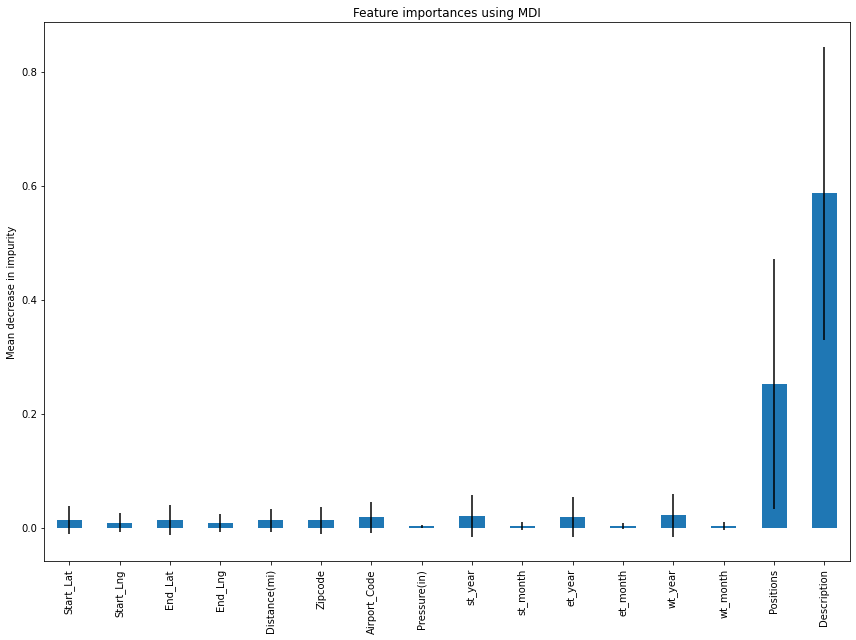

In [17]:
forest_importances = pd.Series(clf.feature_importances_, index=list(X.columns))
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(12,9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

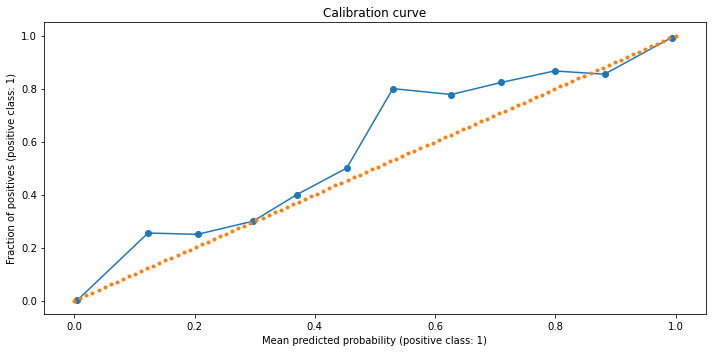

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

yp, xp = calibration_curve(y_test, y_hat_test, n_bins = 12, normalize = True)

xy =np.linspace(0,1,100)

ax.plot(xp, yp,'o-')
ax.plot(xy,xy,'.')
ax.set_title('Calibration curve')
ax.set_xlabel('Mean predicted probability (positive class: 1)')
ax.set_ylabel('Fraction of positives (positive class: 1)')
plt.tight_layout()
plt.show()